In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yfinance import download
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from fcmeans import FCM
from sklearn.datasets import make_blobs
from scipy.stats import shapiro, ttest_ind, skew, kurtosis
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Error Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, f_classif




In [4]:
#pip install pandas_datareader

In [5]:
#pip install pandas numpy matplotlib scikit-learn yfinance

In [9]:
df= pd.read_csv('2010_2025_Tesla Stock Price History.csv')

In [11]:
import yfinance as yf

In [13]:
#tesla = yf.download("TSLA")
#df = yf.download(["TSLA"]);

In [15]:
#df = yf.download("TSLA", start="2010-06-29", end="2025-04-15")

In [17]:
#data = yf.download("TSLA")
#start_date = "2010-06-29"
#end_date = "2025-04-15"

In [19]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,04/15/2025,254.11,249.91,258.75,247.54,79.59M,0.70%
1,04/14/2025,252.35,258.36,261.80,245.93,100.14M,0.02%
2,04/11/2025,252.31,251.84,257.74,241.36,128.95M,-0.04%
3,04/10/2025,252.40,260.00,262.49,239.33,181.72M,-7.27%
4,04/09/2025,272.20,224.69,274.69,223.88,219.43M,22.69%


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3722 entries, 0 to 3721
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3722 non-null   object 
 1   Price     3722 non-null   float64
 2   Open      3722 non-null   float64
 3   High      3722 non-null   float64
 4   Low       3722 non-null   float64
 5   Vol.      3722 non-null   object 
 6   Change %  3722 non-null   object 
dtypes: float64(4), object(3)
memory usage: 203.7+ KB


In [23]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,04/15/2025,254.11,249.91,258.75,247.54,79.59M,0.70%
1,04/14/2025,252.35,258.36,261.80,245.93,100.14M,0.02%
2,04/11/2025,252.31,251.84,257.74,241.36,128.95M,-0.04%
3,04/10/2025,252.40,260.00,262.49,239.33,181.72M,-7.27%
4,04/09/2025,272.20,224.69,274.69,223.88,219.43M,22.69%


In [25]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
3717,07/07/2010,1.05,1.09,1.11,1.00,103.87M,-1.87%
3718,07/06/2010,1.07,1.33,1.33,1.06,103.19M,-16.41%
3719,07/02/2010,1.28,1.53,1.54,1.25,77.13M,-12.33%
3720,07/01/2010,1.46,1.67,1.73,1.35,123.45M,-8.18%
3721,06/30/2010,1.59,1.72,2.03,1.55,257.92M,0.00%


In [27]:
df.shape

(3722, 7)

In [29]:
# To before modeling , I need to prepare the dataset for missing values, what is data types the Datasdet conducts, 
#and correct inconsistencies if there are ones.  
print(df.isnull().sum())

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [31]:
# Now I need to see what type of values the features are. 

print(df.dtypes)

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object


In [33]:
#For easier modeilng is better to modify dataset i which there won't be Tickers or missing values if could be still, 
#renaming Price in Date and checking if "Date" is the index. 

df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
print(df.columns)

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


In [35]:
#df.columns = df.columns.str.replace('_TSLA', '')

In [37]:
# Преобразуем столбец Date в формат datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Проверим, есть ли некорректные (NaT) значения:
print(df[df['Date'].isna()])  # Выведет строки, где дата не распознана


Empty DataFrame
Columns: [Date, Price, Open, High, Low, Vol., Change %]
Index: []


In [39]:


# Убедимся, что столбец 'Date' имеет правильный формат datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Отфильтруем диапазон дат (с 2010-06-29 до 2025-04-15)
df = df[(df['Date'] >= '2010-06-29') & (df['Date'] <= '2025-04-15')]

# Отсортируем по возрастанию
df = df.sort_values(by='Date', ascending=True)

# Убедимся, что формат даты отображается правильно
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

# Проверим, что всё работает:
print(df.head())  # Первые строки
print(df.tail()) 

            Date  Price  Open  High   Low     Vol. Change %
3721  2010-06-30   1.59  1.72  2.03  1.55  257.92M    0.00%
3720  2010-07-01   1.46  1.67  1.73  1.35  123.45M   -8.18%
3719  2010-07-02   1.28  1.53  1.54  1.25   77.13M  -12.33%
3718  2010-07-06   1.07  1.33  1.33  1.06  103.19M  -16.41%
3717  2010-07-07   1.05  1.09  1.11  1.00  103.87M   -1.87%
         Date   Price    Open    High     Low     Vol. Change %
4  2025-04-09  272.20  224.69  274.69  223.88  219.43M   22.69%
3  2025-04-10  252.40  260.00  262.49  239.33  181.72M   -7.27%
2  2025-04-11  252.31  251.84  257.74  241.36  128.95M   -0.04%
1  2025-04-14  252.35  258.36  261.80  245.93  100.14M    0.02%
0  2025-04-15  254.11  249.91  258.75  247.54   79.59M    0.70%


In [41]:
df.head()

# As a reslut we can see now Date has become Index and other features are columns. 

,Date,Price,Open,High,Low,Vol.,Change %
3721,2010-06-30,1.59,1.72,2.03,1.55,257.92M,0.00%
3720,2010-07-01,1.46,1.67,1.73,1.35,123.45M,-8.18%
3719,2010-07-02,1.28,1.53,1.54,1.25,77.13M,-12.33%
3718,2010-07-06,1.07,1.33,1.33,1.06,103.19M,-16.41%
3717,2010-07-07,1.05,1.09,1.11,1.00,103.87M,-1.87%


In [43]:
print(df.dtypes)

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object


In [45]:
df = df.rename(columns={'Vol.': 'Volume'})  # Меняем название столбца

In [47]:
df = df.rename(columns={'Price': 'Close'})  # Меняем название столбца

In [49]:
#df = df.set_index('Date') 

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3722 entries, 3721 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3722 non-null   object 
 1   Close     3722 non-null   float64
 2   Open      3722 non-null   float64
 3   High      3722 non-null   float64
 4   Low       3722 non-null   float64
 5   Volume    3722 non-null   object 
 6   Change %  3722 non-null   object 
dtypes: float64(4), object(3)
memory usage: 232.6+ KB


In [53]:
# Если 'Volume' хранится как object (строка), преобразуем:
df['Volume'] = df['Volume'].astype(str).str.replace('M', '').astype(float) 

In [55]:
df.rename(columns={'Change %': 'Change%'}, inplace=True)  # Если пробел мешаетdf['Change %'] = df['Change %'].astype(str).str.replace('M', '').astype(float) 

In [57]:
print(df.head())

            Date  Close  Open  High   Low  Volume  Change%
3721  2010-06-30   1.59  1.72  2.03  1.55  257.92    0.00%
3720  2010-07-01   1.46  1.67  1.73  1.35  123.45   -8.18%
3719  2010-07-02   1.28  1.53  1.54  1.25   77.13  -12.33%
3718  2010-07-06   1.07  1.33  1.33  1.06  103.19  -16.41%
3717  2010-07-07   1.05  1.09  1.11  1.00  103.87   -1.87%


In [59]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # 'coerce' заменит ошибочные значения на NaT

In [61]:
df.head()

,Date,Close,Open,High,Low,Volume,Change%
3721,2010-06-30,1.59,1.72,2.03,1.55,257.92,0.00%
3720,2010-07-01,1.46,1.67,1.73,1.35,123.45,-8.18%
3719,2010-07-02,1.28,1.53,1.54,1.25,77.13,-12.33%
3718,2010-07-06,1.07,1.33,1.33,1.06,103.19,-16.41%
3717,2010-07-07,1.05,1.09,1.11,1.00,103.87,-1.87%


In [63]:
df.isnull().sum()

Date       0
Close      0
Open       0
High       0
Low        0
Volume     0
Change%    0
dtype: int64

In [65]:
# Now let's see what dataset is consistent 

df.describe()

,Date,Close,Open,High,Low,Volume
count,3722,3722.000000,3722.000000,3722.000000,3722.000000,3722.000000
mean,2017-11-19 16:57:07.834497536,86.114473,86.149103,88.073732,84.077579,96.880548
min,2010-06-30 00:00:00,1.050000,1.080000,1.110000,1.000000,1.780000
25%,2014-03-12 06:00:00,12.332500,12.332500,12.590000,12.105000,49.657500
50%,2017-11-16 12:00:00,18.560000,18.550000,18.810000,18.270000,82.600000
75%,2021-08-01 06:00:00,186.425000,185.495000,189.597500,182.007500,122.520000
max,2025-04-15 00:00:00,479.860000,475.900000,488.540000,457.510000,914.080000
std,NaN,111.902767,112.013748,114.563686,109.186227,77.218952


In [67]:
#The dataset contains 3722 daily records — this aligns well with the period from Tesla IPO (June 2010) to April 2025.

#Price (Close)##:
#Mean: $86, #05
#Median (50%): $18.56,
#Max: $479.7
#Min: ##$1.05
#Standard deviation: $111.9 — very high, which indicates significatnliolai##-- ty.

#Volume:
#Mean dail volume: ~96,#, 9 mil1n
#Min: ~ 1#,, 78 mion
#Max: ~, #-#914 million
#Standard deviation very high (~77##.2 mllion)

#It is  that:
#Tesla trading volume varies wildly, which periods of intense mit could be happening
#market interest, like after some #news or product releases, or probably Elon Musk tweets.

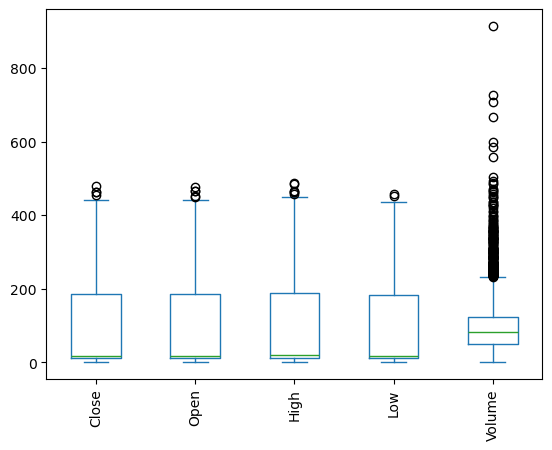

In [69]:
df.plot(kind='box', rot=90);

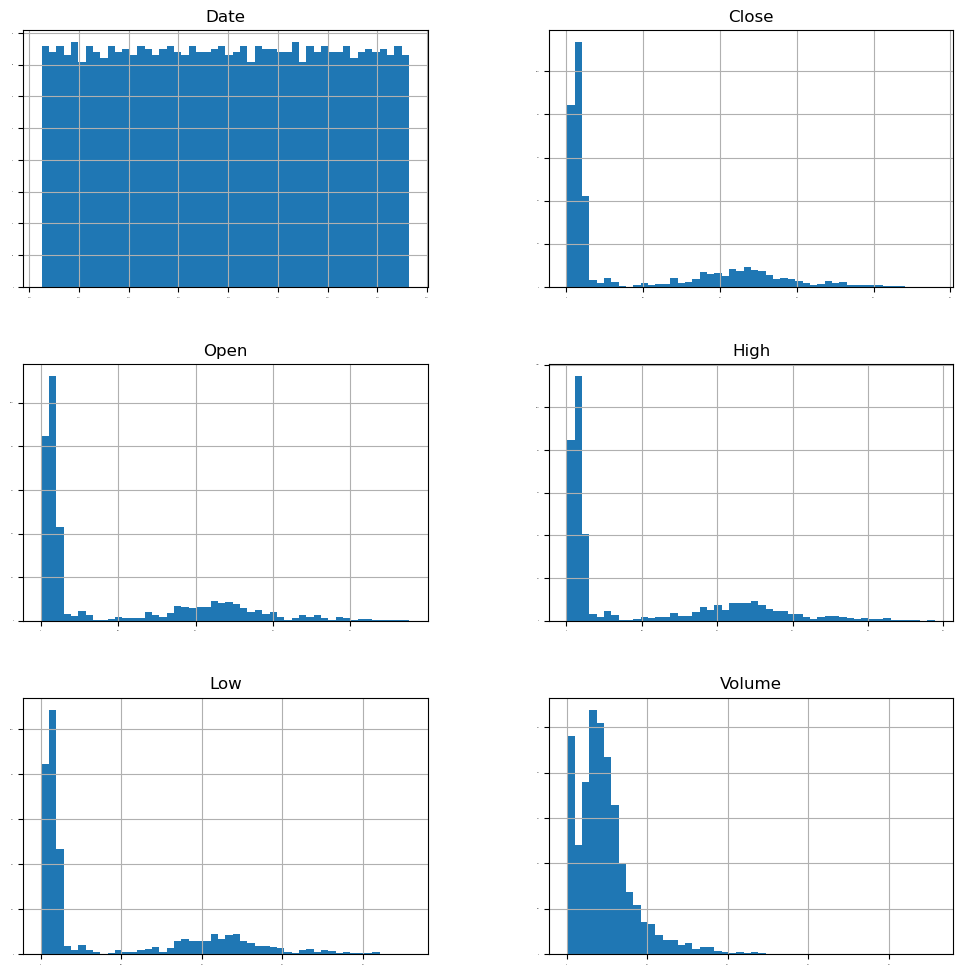

In [71]:
import matplotlib.pyplot as plt

df.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

In [73]:
#"Don’t worry too much about normality when using ARIMA models. They are designed to model patterns in the data, not their distribution."
# Robert Nau (Duke University). 
#Time series models (ARIMA, HWES, SARIMAX) do not work 
#with the form of the distribution but rather with the dependency between observations over time (autocorrelation, seasonality, trend).

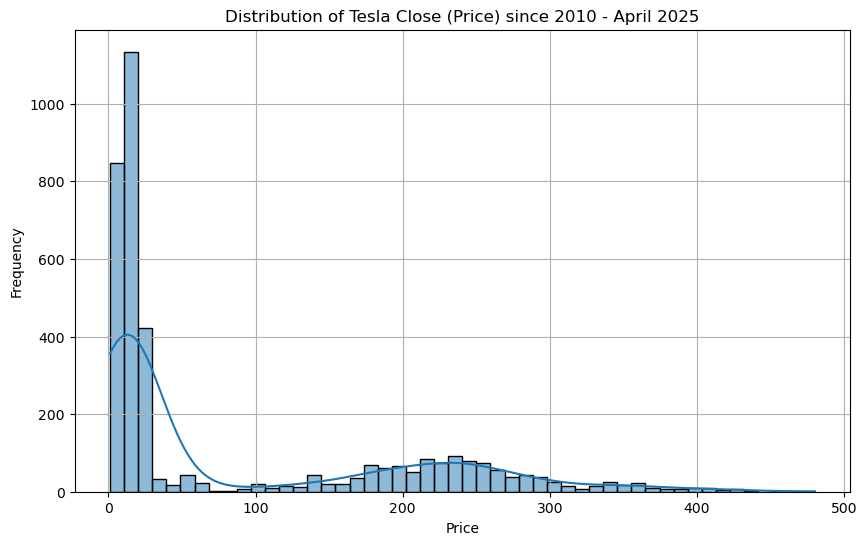

In [75]:

# Distribution of price since 2010 - April 2025
plt.figure(figsize=(10,6))
sns.histplot(df['Close'], kde=True, bins=50)
plt.title('Distribution of Tesla Close (Price) since 2010 - April 2025')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

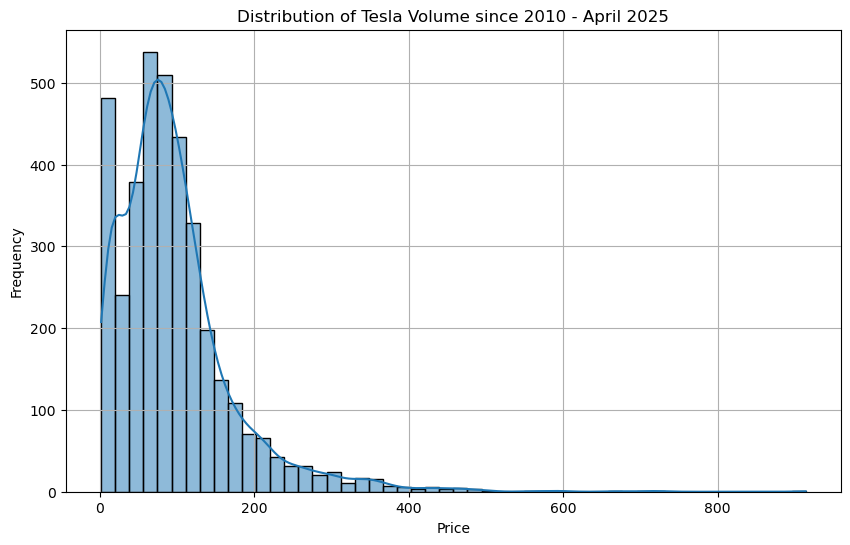

In [77]:
# Distribution of price since 2010 - April 2025
plt.figure(figsize=(10,6))
sns.histplot(df['Volume'], kde=True, bins=50)
plt.title('Distribution of Tesla Volume since 2010 - April 2025')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [79]:
#My decision is to observe the full evolution of the company, where we can see the early stages, periods of growth, 
#market cycles, and crises.
#The period from the beginning of IPO Co gives to see the whole the model from real-world scenarios of growth, decline, and recovery.
#More data - it can give better detection of long-term trends and the structure of seasonality.

In [81]:
#At the beginning let's make a plot of Close (Price) stock from the first day of IPO untill 15th April 2025

In [83]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [85]:
df.set_index('Date', inplace=True)

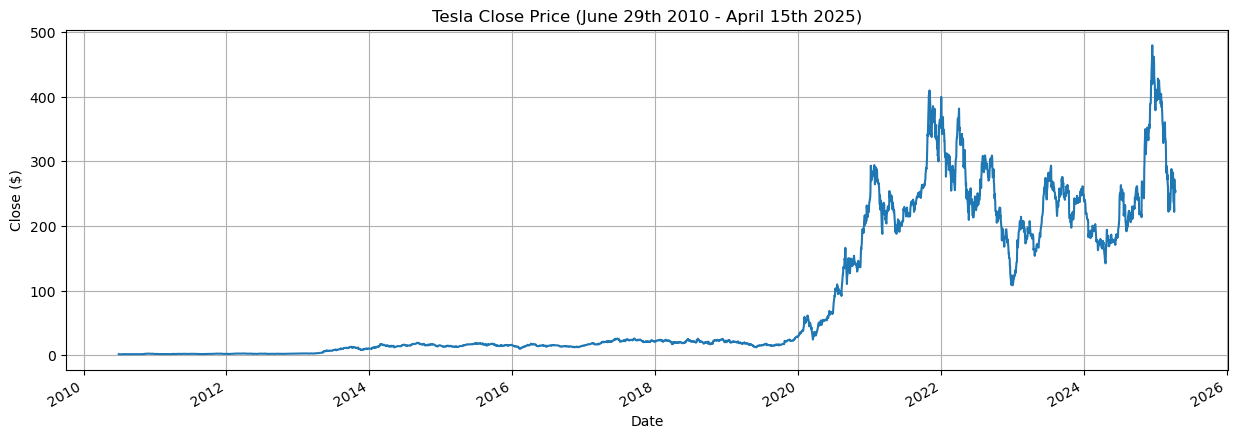

In [87]:
df['Close'].plot(figsize=(15,5), title='Tesla Close Price (June 29th 2010 - April 15th 2025)')
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.grid()
plt.show()

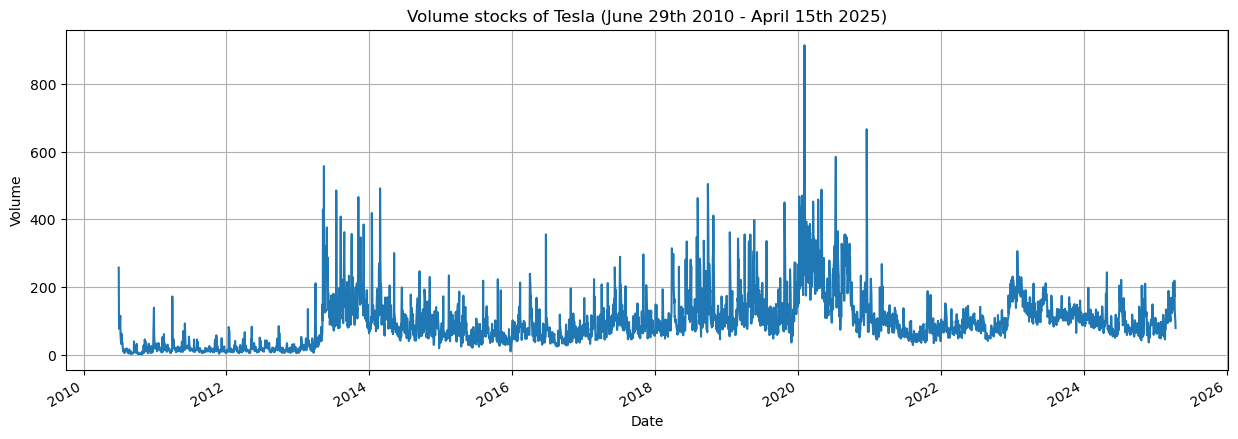

In [89]:


# Check and visualise a Volume trend 


df['Volume'].plot(figsize=(15,5), title='Volume stocks of Tesla (June 29th 2010 - April 15th 2025)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid()
plt.show()

In [91]:
# As one of the essential tasks is to predict a price (Close) for Tesla for next April 2026, let's model at the beginning the Close. 

#Being able to analyse a Tesla stock and how it performs via ARIMA or ARMA, SARIMA models and 
#finally predict the price for next 2026 we need to learn the followng factors:

#Trend,
#Seasonality,
#Ciclicity,
#Resudials 
#And finally, based on all of that to make a determination of a Series Time.



In [93]:
#it is crucial to carefully analyze the key time series components:

#Trend:
#Detecting the long-term movement of Tesla’s stock price over the years, such as periods of steady growth, corrections, or plateau phases.
#Tesla has a strong upward and curently  downward trends. 
# Upward trend we saw after a major event like product launching EV truck. 
#Downward trend we can observe in current days when E.Mask is heading DOGE and EV cars are boycotted do not buy in entrire world. 

#Focus on 'Close' price
df = df[['Close']]




In [95]:
df.head()

,Close
Date,
2010-06-30,1.59
2010-07-01,1.46
2010-07-02,1.28
2010-07-06,1.07
2010-07-07,1.05


In [97]:
df.tail()

,Close
Date,
2025-04-09,272.20
2025-04-10,252.40
2025-04-11,252.31
2025-04-14,252.35
2025-04-15,254.11


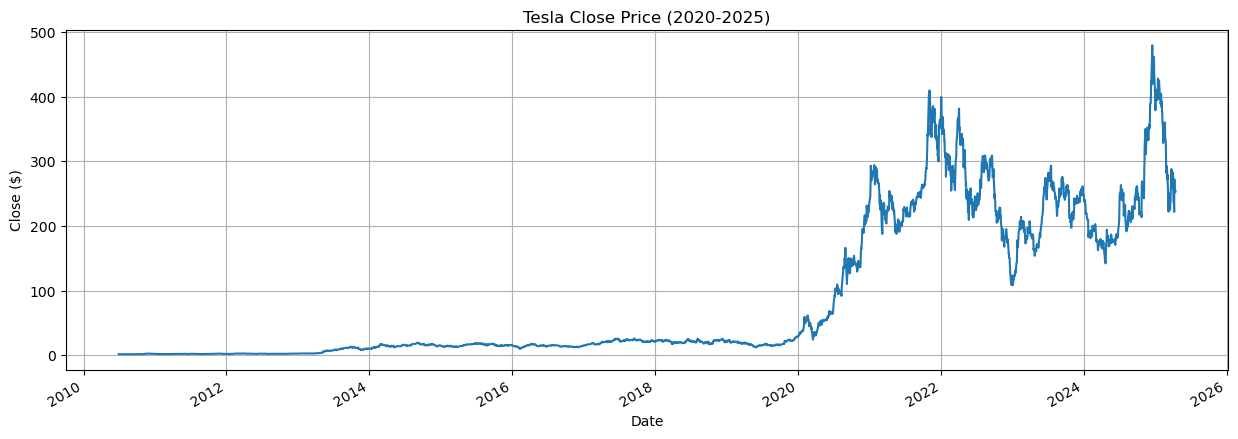

In [99]:
# Check and visualise a trend 


df['Close'].plot(figsize=(15,5), title='Tesla Close Price (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.grid()
plt.show()

In [101]:
#Seasonality:
# It helps to identify repeating patterns that occur at regular intervals, such as quarterly financial reoprting effects, 
#earnings season impacts, or even market rallies, particularly at the end of year.

# Cyclicality:
# helps us to understand longer-term cycles that influence in cause of diverce economic factors like market booms or recessions.
# In our case with Tesla it may reflect broader technology sector that we will observe later in this Juoyter Note in 
# a sector of Clustering with S&P 500.  

#Residuals:
#Or in Traiding world it calls Noises. After removing trend and seasonality we can still observe the irregular fluctuations 
#that to must be checked and considered for precisional modelling.

In [103]:
print(df.index)
print(type(df.index))

DatetimeIndex(['2010-06-30', '2010-07-01', '2010-07-02', '2010-07-06',
               '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12',
               '2010-07-13', '2010-07-14',
               ...
               '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-07',
               '2025-04-08', '2025-04-09', '2025-04-10', '2025-04-11',
               '2025-04-14', '2025-04-15'],
              dtype='datetime64[ns]', name='Date', length=3722, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [105]:
# Based on the decomposition above, there is no strong or stable seasonality in the Tesla closing prices with years period.
#The seasonal component appears weak and erratic, suggesting that trend and noise dominate the time series behavior.
#The seasonal component appears weak and erratic, suggesting that trend and noise dominate the time series behavior.


# Period/Decompositon 1 = 21 Traiding days  → First Decomposition
#Trend is okay, but Seasonality is completely flat and noisy, almost meaningless.
#Residuals are much larger and chaotic.


#Period/Decompostion 2  = 252 (Trading Days ~1 Year) → Second Decomposition
#Trend looks smooth and meaningful: captures Tesla’s major growth (2019–2021) and later flattening.
#Seasonality shows clear, strong repeating patterns — yearly cycles.
#Residuals are relatively small and random after 2019 (good for modeling).
#This decomposition looks very clean.
#Strong annual seasonality captured.


#This guides us that:
#21 Traiding Days Decompostion1 makes sense for Time series (resampled data), not for monthly data.


#Conclusion: What to take for further modeling?

# In my opinion is better to use period = 30 trading days:

# 30 days ≈ 1 month of market activity
#Monthly cycles are often observed in investor behavior (e.g., earnings cycles, portfolio adjustments, salary-based investments)
#It's short enough to capture patterns and regularities that 252-day or even 90-day seasonality might miss

#Seasonal SARIMA - repeating yearly patterns in trading days, and will take seasonal period = 30 days 
#Holt-Winters - seasonal period = 30 days


In [107]:
# Resample to monthly average to better see patterns
#df_monthly = df['Close'].resample('M').mean() # that minds Month or Monthly trend. 


In [109]:
print(df.columns)
print(df.head())

Index(['Close'], dtype='object')
            Close
Date             
2010-06-30   1.59
2010-07-01   1.46
2010-07-02   1.28
2010-07-06   1.07
2010-07-07   1.05


In [111]:
print(df.index)  # Должен показывать даты без ошибок
#print(len(df))  # Должен совпадать с длиной индекса

DatetimeIndex(['2010-06-30', '2010-07-01', '2010-07-02', '2010-07-06',
               '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12',
               '2010-07-13', '2010-07-14',
               ...
               '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-07',
               '2025-04-08', '2025-04-09', '2025-04-10', '2025-04-11',
               '2025-04-14', '2025-04-15'],
              dtype='datetime64[ns]', name='Date', length=3722, freq=None)


In [113]:
#df.index = pd.to_datetime(df.index, format='%m/%d/%Y')  # Convert correctly
#df = df.sort_index(ascending=False)  # Keep descending order (2025 → 2010)

In [115]:
print(df.index)

DatetimeIndex(['2010-06-30', '2010-07-01', '2010-07-02', '2010-07-06',
               '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12',
               '2010-07-13', '2010-07-14',
               ...
               '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-07',
               '2025-04-08', '2025-04-09', '2025-04-10', '2025-04-11',
               '2025-04-14', '2025-04-15'],
              dtype='datetime64[ns]', name='Date', length=3722, freq=None)


In [117]:
df.index = pd.to_datetime(df.index, errors='coerce')  # Convert index to datetime format
df = df.sort_index(ascending=False)  # Keep descending order (2025 → 2010)

In [119]:
print(df.index.min(), df.index.max())  # Check dataset date range

2010-06-30 00:00:00 2025-04-15 00:00:00


In [121]:
df = df.dropna()  # Remove any invalid rows

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3722 entries, 2025-04-15 to 2010-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3722 non-null   float64
dtypes: float64(1)
memory usage: 58.2 KB


In [125]:
df.isnull().sum()

Close    0
dtype: int64

In [127]:
print(df.loc["2025-02-19"])  # Test if this date exists
print(df.loc["2025-04-15"])  # Test if this date exists

Close    360.56
Name: 2025-02-19 00:00:00, dtype: float64
Close    254.11
Name: 2025-04-15 00:00:00, dtype: float64


In [129]:
df.index = pd.to_datetime(df.index, errors='coerce')  # Ensure correct datetime format
df = df.sort_index(ascending=True)  # Теперь данные идут от 2019 к 2025

In [131]:
print(df.index.min(), df.index.max())  # Check dataset date range
print("2025-02-19" in df.index)  # Check if start_date exists
print("2025-04-15" in df.index)  # Check if end_date exists

2010-06-30 00:00:00 2025-04-15 00:00:00
True
True


In [133]:
df.head(45)

,Close
Date,
2010-06-30,1.59
2010-07-01,1.46
2010-07-02,1.28
2010-07-06,1.07
2010-07-07,1.05
2010-07-08,1.16
2010-07-09,1.16
2010-07-12,1.14
2010-07-13,1.21


In [135]:
start_date = pd.Timestamp("2025-02-19")
end_date = pd.Timestamp("2025-04-15")

df_decomposition = df.loc[start_date:end_date]  # Match descending order
print(df_decomposition.shape[0])  # Check if data is correctly selected

40


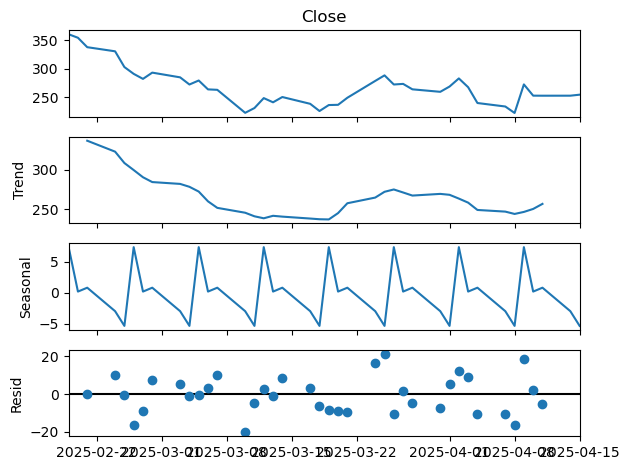

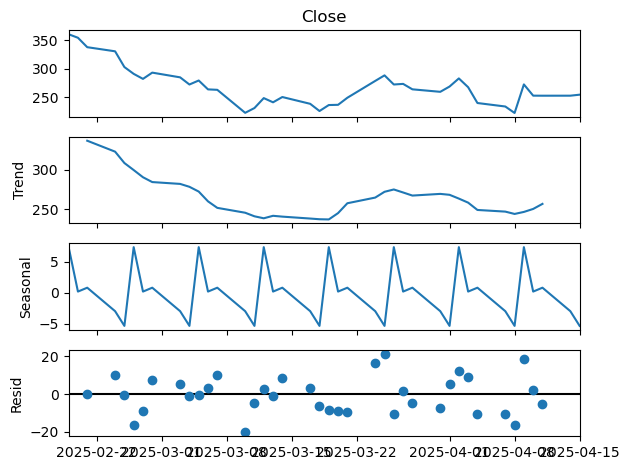

In [137]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df_decomposition['Close'], model='additive', period=5)# decomposition 
decomposition.plot()

In [139]:
from statsmodels.tsa.stattools import adfuller

# Убедимся, что нет пропущенных значений
df_filtered = df.dropna()

# Выполним ADF тест
result = adfuller(df_filtered['Close'])

# Выведем результаты
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Интерпретация
if result[1] < 0.05:
    print("Ряд стационарен (p-value < 0.05). Можно строить ARIMA без дифференцирования.")
else:
    print("Ряд НЕ стационарен (p-value > 0.05). Нужно применить дифференцирование.")

ADF Statistic: -1.4071852842843595
p-value: 0.5788265963726316
Ряд НЕ стационарен (p-value > 0.05). Нужно применить дифференцирование.


In [141]:
# Take the difference
import numpy as np
df_diff = df.dropna()  # Удаляем пропущенные значения
df_diff['Close_diff'] = df_diff['Close'].diff().dropna()  # 1 diffecernce

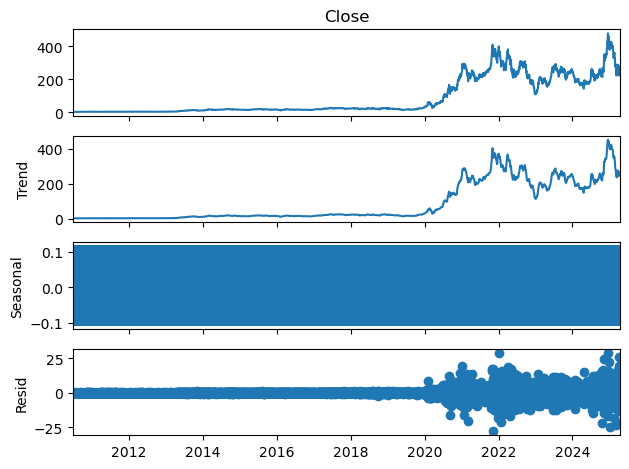

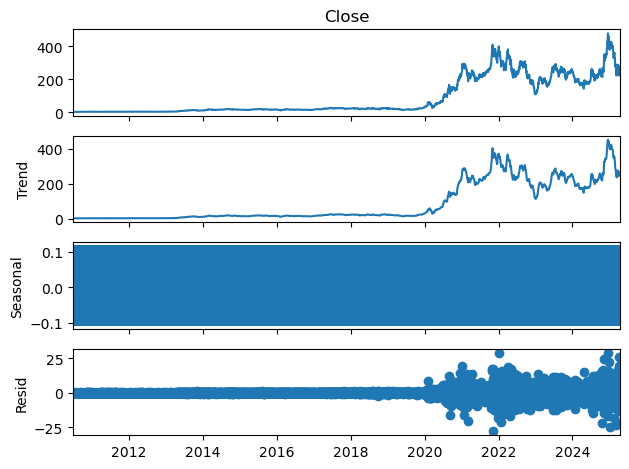

In [143]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df_diff['Close'], model='addictive', period=5)
decomposition.plot()

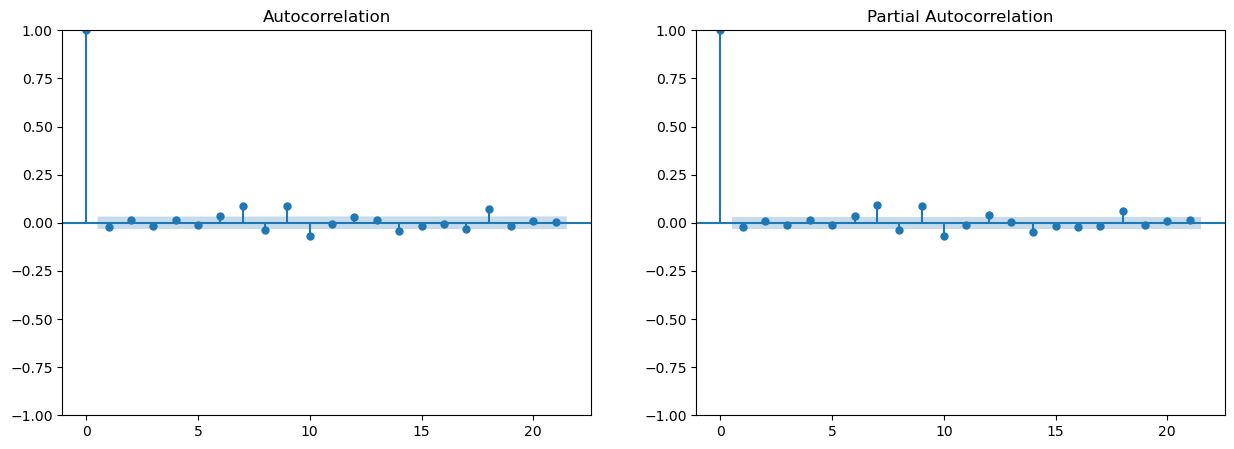

In [145]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF for determining  q (MA компонента)
plot_acf(df_diff['Close_diff'].dropna(), lags=21, ax=axes[0])

# PACF for determining  p (AR компонента)
plot_pacf(df_diff['Close_diff'].dropna(), lags=21, ax=axes[1])

plt.show()

In [147]:
from statsmodels.tsa.arima.model import ARIMA


# A nested loop is written to calculate the AIC values
aicVal=[]# Acai value 
for d in range(0,1): # Differencing orders (0 or 1)
    for ari in range(0, 3):  # AR order (p): 0,1,2
        for maj in range(0, 3):  # MA order (q): 0,1,2
            try:
                arima_obj = ARIMA(df_diff['Close'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[[0, 0, 0, 45683.618601287046], [0, 0, 1, 40764.4513736619], [0, 0, 2, 36813.40102024997], [1, 0, 0, 23343.16334232742], [1, 0, 1, 23343.811758985998], [1, 0, 2, 23345.277000968315], [2, 0, 0, 23343.778788410626], [2, 0, 1, 23344.675117547595], [2, 0, 2, 23344.647407327193]]


In [149]:
# as we made a Difference , our d will be 1
#the most small composition [1, 0, 0, 23343.126742089058], 
# where p (AR) = 1, 
#d (Difference)= 1, 
#q (MA)= 0.  

In [151]:
import warnings
warnings.filterwarnings("ignore")

In [153]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(df_diff['Close'], order=(1, 1, 0))
model_arima_fit = model_arima.fit()

print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3722
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -11662.641
Date:                Sat, 17 May 2025   AIC                          23329.281
Time:                        22:01:23   BIC                          23341.725
Sample:                             0   HQIC                         23333.708
                               - 3722                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0199      0.008     -2.427      0.015      -0.036      -0.004
sigma2        30.8962      0.239    129.441      0.000      30.428      31.364
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [155]:
df.index = pd.to_datetime(df.index, errors='coerce')  # Убедимся, что индекс — даты
df = df.sort_index(ascending=True)  # Теперь данные идут от 2019 к 2025

In [157]:
from statsmodels.tsa.arima.model import ARIMA

# Определяем параметры (p, d, q) по ACF/PACF
p, d, q = 1, 1, 0  # Можно уточнить по анализу ACF/PACF

# Обучаем ARIMA модель
model_arima = ARIMA(df['Close'], order=(p, d, q))
model_arima_fit = model_arima.fit()

In [159]:
# Задаем целевую дату для прогноза:
forecast_date = pd.to_datetime("2025-02-19")

In [161]:
# Определяем число дней до прогноза (предполагаем, что прогнозируем для будущей даты, после конца обучающего набора)
last_date = df.index[-1]
num_days = (forecast_date - last_date).days

In [165]:
print(f"Last_date: {df.index[-1]}")  

Last_date: 2025-04-15 00:00:00


In [169]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the model (example for ARIMA(1,1,0))
model = ARIMA(df['Close'], order=(1,1,0))
model_fit = model.fit()  # This creates the model_fit object

In [171]:
if num_days <= 0:
    forecast_val = model_fit.predict(start=forecast_date, end=forecast_date)
    forecast_index = [forecast_date]
else:
    forecast_val = model_fit.get_forecast(steps=num_days).predicted_mean

In [173]:
# Выведем прогноз для целевой даты:
if forecast_date in forecast_val.index:
    predicted_price = forecast_val.loc[forecast_date]
    print(f"Прогнозируемая цена на {forecast_date.date()}: {predicted_price:.2f}")
else:
    print("Целевая дата не попала в прогнозный интервал.")

Прогнозируемая цена на 2025-02-19: 354.14


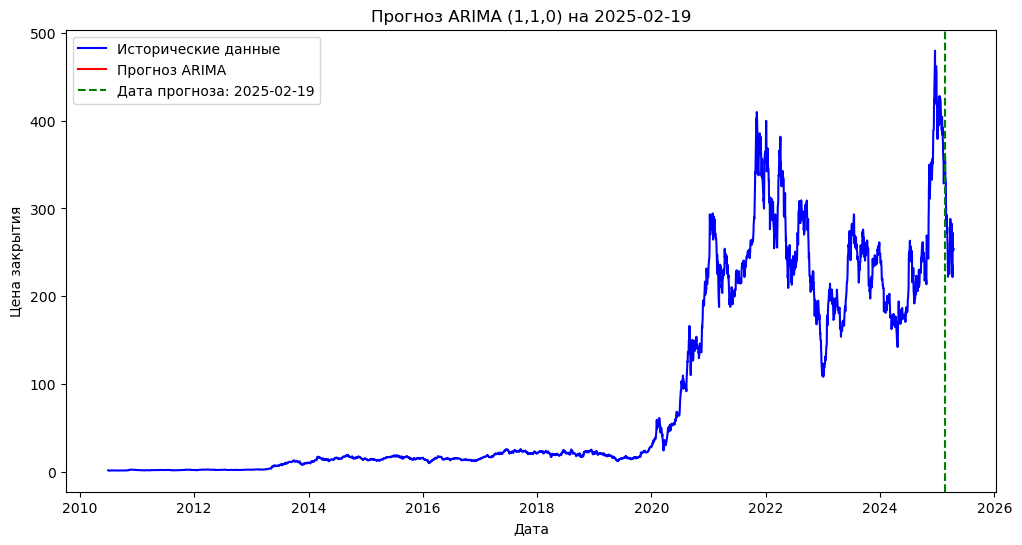

In [175]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label="Исторические данные", color="blue")
plt.plot(forecast_val, label="Прогноз ARIMA", color="red")
plt.axvline(x=forecast_date, color="green", linestyle="--", 
            label=f"Дата прогноза: {forecast_date.date()}")
plt.xlabel("Дата")
plt.ylabel("Цена закрытия")
plt.title("Прогноз ARIMA (1,1,0) на 2025-02-19")
plt.legend()
plt.show()

In [177]:
# This forcasting price was very prcice but to Open day rather than to Close. 
# In this case I'm going to try to apply SARIMA and compare. 

SARIMA 

In [180]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Подготовка данных: индекс должен быть datetime и отсортирован по возрастанию
df.index = pd.to_datetime(df.index, errors='coerce')
df = df.sort_index(ascending=True)

In [182]:
# Aplly SARIMA : (1, 1, 0) with 5 days (1, 1, 0, 5) 
model_sarima = SARIMAX(df['Close'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 5))
model_sarima_fit = model_sarima.fit(disp=False)
print(model_sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 3722
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 5)   Log Likelihood              -12467.422
Date:                           Sat, 17 May 2025   AIC                          24940.844
Time:                                   22:06:02   BIC                          24959.505
Sample:                                        0   HQIC                         24947.484
                                          - 3722                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0483      0.007     -6.678      0.000      -0.062      -0.034
ar.S.L5       -0.4734      0.007    -69.118

In [184]:
# Зададим целевую дату прогноза — 2025-02-19:
forecast_date = pd.to_datetime("2025-02-19")
last_date = df.index[-1]
num_days = (forecast_date - last_date).days

In [186]:
# Прогноз:
if num_days <= 0:
    forecast_val = model_sarima_fit.predict(start=forecast_date, end=forecast_date)
    forecast_index = [forecast_date]
else:
    forecast_obj = model_sarima_fit.get_forecast(steps=num_days)
    forecast_val = forecast_obj.predicted_mean
    forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_days, freq='D')
    forecast_val.index = forecast_index

if forecast_date in forecast_val.index:
    predicted_price = forecast_val.loc[forecast_date]
    print(f"Прогнозируемая цена на {forecast_date.date()} по SARIMA: {predicted_price:.2f}")
else:
    print("Целевая дата не попала в прогнозный интервал.")

Прогнозируемая цена на 2025-02-19 по SARIMA: 345.77


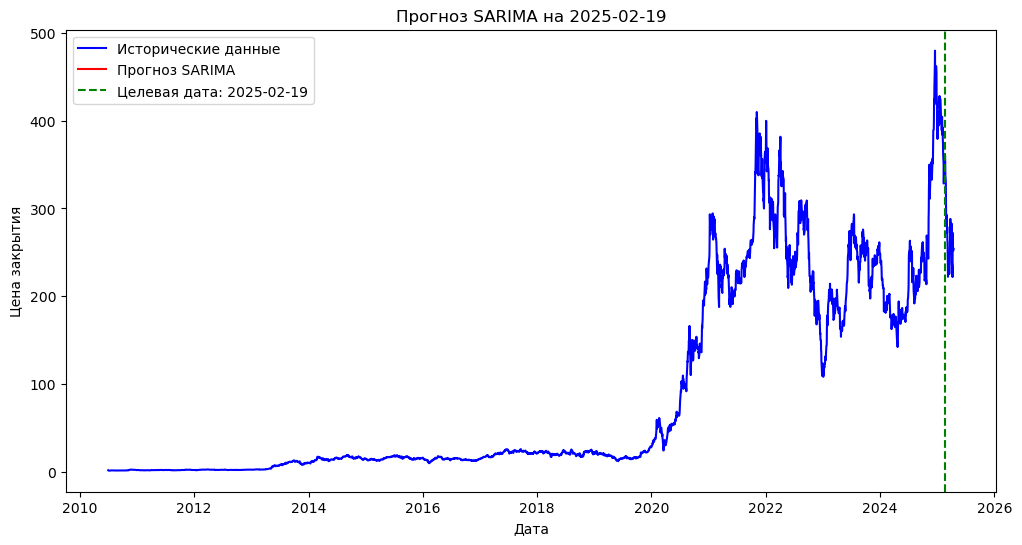

In [188]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label="Исторические данные", color="blue")
plt.plot(forecast_val, label="Прогноз SARIMA", color="red")
plt.axvline(x=forecast_date, color="green", linestyle="--", label=f"Целевая дата: {forecast_date.date()}")
plt.xlabel("Дата")
plt.ylabel("Цена закрытия")
plt.title("Прогноз SARIMA на 2025-02-19")
plt.legend()
plt.show()

LSTM

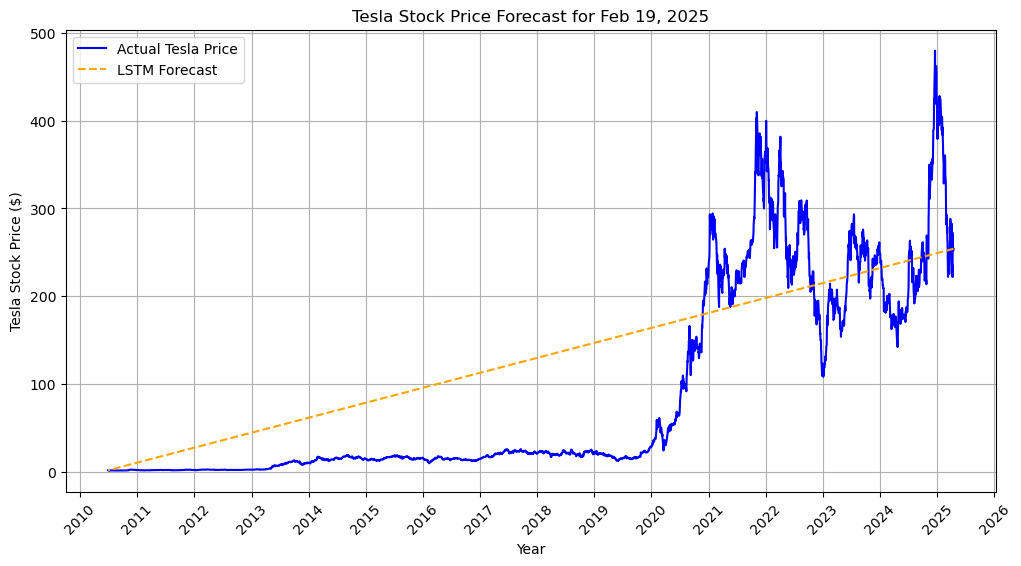

In [191]:
import matplotlib.dates as mdates  # Import matplotlib date formatting

plt.figure(figsize=(12,6))

# Plot actual stock prices
plt.plot(df.index, df['Close'], color="blue", label="Actual Tesla Price")

# Add forecast point with trend
plt.plot([df.index[-1], df.index[0]], [df['Close'].iloc[-1], df['Close'].iloc[0]],
         color="orange", linestyle="dashed", label="LSTM Forecast")

# Style the x-axis for years like in your example
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

# Labels and grid
plt.xlabel("Year")
plt.ylabel("Tesla Stock Price ($)")
plt.legend()
plt.title("Tesla Stock Price Forecast for Feb 19, 2025")
plt.grid(True)
plt.show()

ARIMA Forecast for April 15, 2026 

In [194]:
# Applying Arima (similar composition )

series_diff = df_diff['Close']  # Use differenced data

In [196]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(series_diff, order=(1, 1, 0))
model_fit = model.fit()

print(model_fit.summary())  # Check model details

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3722
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -11662.641
Date:                Sat, 17 May 2025   AIC                          23329.281
Time:                        22:06:13   BIC                          23341.725
Sample:                             0   HQIC                         23333.708
                               - 3722                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0199      0.008     -2.427      0.015      -0.036      -0.004
sigma2        30.8962      0.239    129.441      0.000      30.428      31.364
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [198]:
from statsmodels.tsa.arima.model import ARIMA

# Определяем параметры (p, d, q) по ACF/PACF
p, d, q = 1, 1, 0  # Можно уточнить по анализу ACF/PACF

# Обучаем ARIMA модель
model_arima = ARIMA(df_diff['Close'], order=(p, d, q))
model_arima_fit = model_arima.fit()

In [200]:
# Задаем целевую дату для прогноза:
forecast_date = pd.to_datetime("2026-04-15")

In [202]:
# Forecast up to April 15, 2026
forecast_steps = (pd.to_datetime("2026-04-15") - df_diff.index.max()).days
result = model_fit.get_forecast(steps=forecast_steps)
forecast = result.predicted_mean  # Forecasted values

In [204]:
# Reverse differencing to get actual stock prices
last_close_price = df_diff['Close'].iloc[-1]
forecast_price = last_close_price + forecast.cumsum()

In [206]:
# Determination days until forecaste date 
last_date = df.index[-1]
num_days = (forecast_date - last_date).days

In [208]:
print(f"Last_date: {df.index[-1]}")
print(f"Forecast_date: {forecast_date}")
print(f"Days_for_forecast: {num_days}")


Last_date: 2025-04-15 00:00:00
Forecast_date: 2026-04-15 00:00:00
Days_for_forecast: 365


In [212]:
predicted_diff = model_fit.get_forecast(steps=1).predicted_mean.iloc[0]  # For 1-day forecast

In [214]:
last_close_price = df['Close'].iloc[-1]  # Last actual closing price
predicted_price = last_close_price + predicted_diff  # Undo differencing

print(f"Predicted Tesla closing price on April 15, 2026: ${predicted_price:.2f}")

Predicted Tesla closing price on April 15, 2026: $508.18


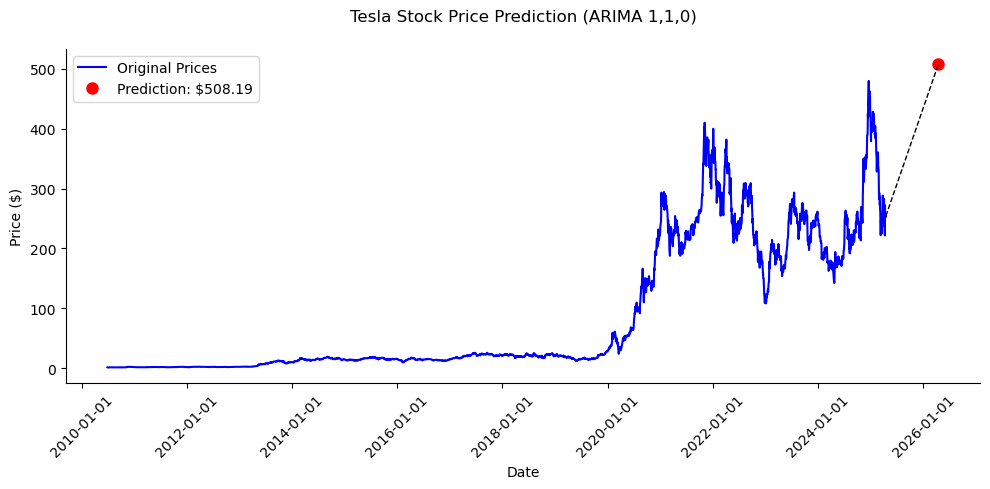

In [216]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter


last_close_price = df_diff['Close'].iloc[-1]  # Last actual price
predicted_price = 508.19  #  predicted price

# Convert dates to datetime objects
last_date = pd.to_datetime(df_diff.index[-1])
prediction_date = pd.to_datetime("2026-04-15")

# Create the plot
plt.figure(figsize=(10, 5))

# Plot historical data
plt.plot(df_diff.index, df_diff['Close'], 'b-', label='Original Prices')

# Mark the prediction point
plt.plot(prediction_date, predicted_price, 'ro', markersize=8, 
         label=f'Prediction: ${predicted_price:.2f}')

# Connect last point to prediction
plt.plot([last_date, prediction_date], [last_close_price, predicted_price], 
         'k--', linewidth=1)

# Format the x-axis
date_format = DateFormatter("%Y-%m-%d")
plt.gca().xaxis.set_major_formatter(date_format)

# Add labels
plt.title("Tesla Stock Price Prediction (ARIMA 1,1,0)", pad=20)
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()

# Rotate x-axis labels and clean up
plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

SARIMA Forecast for April 15, 2026

In [219]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Подготовка данных: индекс должен быть datetime и отсортирован по возрастанию
df.index = pd.to_datetime(df.index, errors='coerce')
df = df.sort_index(ascending=True)

In [221]:
# Aplly SARIMA : (1, 1, 0) with 5 days (1, 1, 0, 5) 
model_sarima = SARIMAX(df_diff['Close'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 5))
model_sarima_fit = model_sarima.fit(disp=False)
print(model_sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 3722
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 5)   Log Likelihood              -12467.422
Date:                           Sat, 17 May 2025   AIC                          24940.844
Time:                                   22:07:40   BIC                          24959.505
Sample:                                        0   HQIC                         24947.484
                                          - 3722                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0483      0.007     -6.678      0.000      -0.062      -0.034
ar.S.L5       -0.4734      0.007    -69.118

In [223]:
# Зададим целевую дату прогноза — 2026-04-15:
forecast_date = pd.to_datetime("2026-04-15")
last_date = df.index[-1]
num_days = (forecast_date - last_date).days

In [225]:
# Прогноз:
if num_days <= 0:
    forecast_val = model_sarima_fit.predict(start=forecast_date, end=forecast_date)
    forecast_index = [forecast_date]
else:
    forecast_obj = model_sarima_fit.get_forecast(steps=num_days)
    forecast_val = forecast_obj.predicted_mean
    forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_days, freq='D')
    forecast_val.index = forecast_index

if forecast_date in forecast_val.index:
    predicted_price = forecast_val.loc[forecast_date]
    print(f"Прогнозируемая цена на {forecast_date.date()} по SARIMA: {predicted_price:.2f}")
else:
    print("Целевая дата не попала в прогнозный интервал.")

Прогнозируемая цена на 2026-04-15 по SARIMA: 742.95


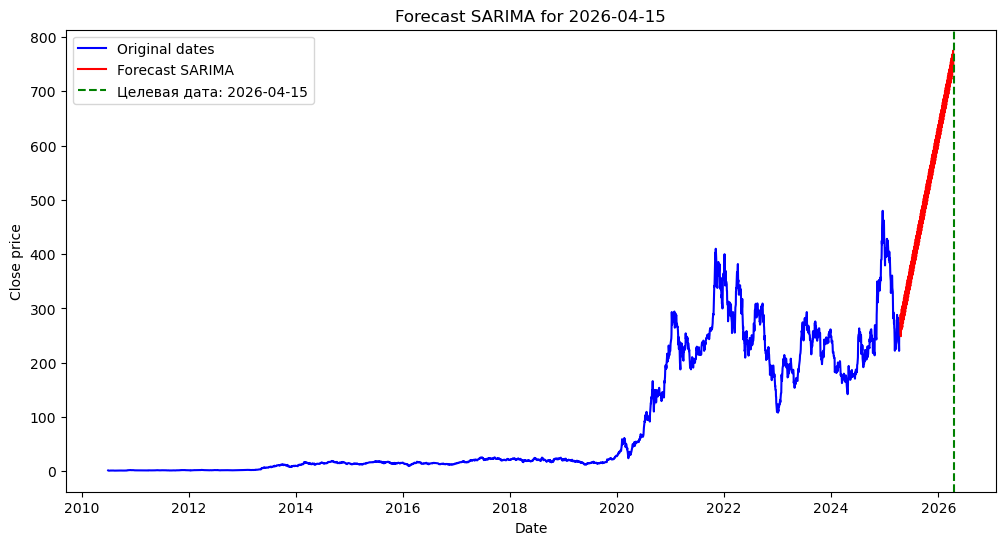

In [227]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df_diff['Close'], label="Original dates", color="blue")
plt.plot(forecast_val, label="Forecast SARIMA", color="red")
plt.axvline(x=forecast_date, color="green", linestyle="--", label=f"Целевая дата: {forecast_date.date()}")
plt.xlabel("Date")
plt.ylabel("Close price")
plt.title("Forecast SARIMA for 2026-04-15")
plt.legend()
plt.show()

Clustering Index NASDAQ & Tesla 

In [231]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

# Загружаем данные Tesla и NASDAQ
tesla_df = pd.read_csv("2010_2025_Tesla Stock Price History.csv", index_col="Date", parse_dates=True)
nasd_df = pd.read_csv("Nasdaq 100 Historical Data.csv", index_col="Date", parse_dates=True)

# This is just a comment.



In [237]:
df_j = tesla_df.join(nasd_df, how='inner', lsuffix='_TSLA', rsuffix='_NASDAQ')



In [239]:
df_j.head()

,Price_TSLA,Open_TSLA,High_TSLA,Low_TSLA,Vol._TSLA,Change %_TSLA,Price_NASDAQ,Open_NASDAQ,High_NASDAQ,Low_NASDAQ,Vol._NASDAQ,Change %_NASDAQ
Date,,,,,,,,,,,,
2025-04-15,254.11,249.91,258.75,247.54,79.59M,0.70%,"18,830.23","18,831.98","19,004.17","18,754.87",273.21M,0.18%
2025-04-14,252.35,258.36,261.80,245.93,100.14M,0.02%,"18,796.02","19,095.49","19,115.15","18,614.76",361.31M,0.57%
2025-04-11,252.31,251.84,257.74,241.36,128.95M,-0.04%,"18,690.05","18,309.29","18,728.95","18,153.32",459.77M,1.89%
2025-04-10,252.40,260.00,262.49,239.33,181.72M,-7.27%,"18,343.57","18,626.11","18,710.58","17,794.50",625.94M,-4.19%
2025-04-09,272.20,224.69,274.69,223.88,219.43M,22.69%,"19,145.06","17,116.53","19,234.02","17,082.36",990.41M,12.02%


In [241]:
print(df_j.dtypes)

Price_TSLA         float64
Open_TSLA          float64
High_TSLA          float64
Low_TSLA           float64
Vol._TSLA           object
Change %_TSLA       object
Price_NASDAQ        object
Open_NASDAQ         object
High_NASDAQ         object
Low_NASDAQ          object
Vol._NASDAQ         object
Change %_NASDAQ     object
dtype: object


In [243]:
tesla_df.rename(columns={'Price': 'Close_Tesla', 'Open': 'Open_Tesla', 'High': 'High_Tesla', 'Low': 'Low_Tesla', 'Vol.': 'Vol_Tesla', 'Change %': 'Change_Tesla'}, inplace=True)
nasd_df.rename(columns={'Price': 'Close_NASDAQ', 'Open': 'Open_NASDAQ', 'High': 'High_NASDAQ', 'Low': 'Low_NASDAQ', 'Vol.': 'Vol_NASDAQ', 'Change %': 'Change_NASDAQ'}, inplace=True)


In [245]:
print("Available columns df_j:", df_j.columns)

Available columns df_j: Index(['Price_TSLA', 'Open_TSLA', 'High_TSLA', 'Low_TSLA', 'Vol._TSLA',
       'Change %_TSLA', 'Price_NASDAQ', 'Open_NASDAQ', 'High_NASDAQ',
       'Low_NASDAQ', 'Vol._NASDAQ', 'Change %_NASDAQ'],
      dtype='object')


In [247]:
print(df_j.dtypes)

Price_TSLA         float64
Open_TSLA          float64
High_TSLA          float64
Low_TSLA           float64
Vol._TSLA           object
Change %_TSLA       object
Price_NASDAQ        object
Open_NASDAQ         object
High_NASDAQ         object
Low_NASDAQ          object
Vol._NASDAQ         object
Change %_NASDAQ     object
dtype: object


In [249]:
# Удаляем запятые и конвертируем в числовой формат

df_j['Price_NASDAQ'] = df['Price_NASDAQ'].str.replace(',', '').astype(float)

KeyError: 'Price_NASDAQ'

In [ ]:
# Нормализуем данные
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(df[['Price_TSLA', 'Price_NASDAQ']])

In [ ]:
#df_j.head()

In [ ]:
# Удаляем запятые и конвертируем в числовой формат
#df_j['Close_Tesla'] = df_j['Close_Tesla'].astype(str).str.replace(',', '').astype(float)
#df_j['Close_NSD'] = df_j['Close_NSD'].astype(str).str.replace(',', '').astype(float)

In [ ]:
#print(df_j.dtypes)

In [ ]:
#  KMeans 
#from sklearn.cluster import KMeans

# Determine number of Clusters (например, 3)
#kmeans = KMeans(n_clusters=3, random_state=42)

# Upload clusters
#df_j['Cluster'] = kmeans.fit_predict(df_j[['Close_Tesla', 'Close_NSD']])

In [ ]:
#print(df_j.columns)

In [ ]:
#df_j.rename(columns={'Price_TSLA': 'Close_Tesla', 'Price_NASDAQ': 'Close_NSD'}, inplace=True)

In [ ]:
#df_j.head()

In [ ]:
# Визуализируем кластеры
#sns.scatterplot(x=df_j.index, y=df_j['Close_Tesla'], hue=df['Cluster'], palette="coolwarm")
#plt.title("Clusters Tesla и NASDAQ")

#plt.show()

In [ ]:
#df_decomposition = df.loc[end_date:start_date]

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decomposition Seasonality
try:
    decomposition = seasonal_decompose(df['Close'], model='additive', period=30) # 30 traiding days 
except ValueError as e:
    print(f"Decomposition: {e}")
    print("Проверьте:")
    print("1. There is a gap")
    print("2. There is enough values for a period (min 2 full periods)")
    raise

# Построение графиков
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed Closing Price', color='blue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
#Decomposition 2 - is 252 dayly average traiding period that considers 252 traiding days per year. 

decomposition2 = seasonal_decompose(df['Close'], model='additive', period=252)  # 252 — is avarge trading days per year 
decomposition2.plot()
plt.show()

In [ ]:
decomposition3 = seasonal_decompose(df['Close'], model='additive', period=90)  # 90 — is quartly  
decomposition3.plot()
plt.show()

In [ ]:
#pip install numpy==1.26.4

Series Time/ Hypothesis Stationary 

linkcode
ADF Test for Stationarity

ADF test is a common statistical test used to test whether a given Time Series is Stationary or not. It is one of most commonly used statistical test when it comes to analyzing the stationarity of a series.

Null Hypothesis :- The Time Series is not stationary.

Alternate Hypothesis :- The Time series is stationary.

p-value > 0.05 :- Fails to reject null hypothesis, the data has a unit root and not stationary.

p-value < 0.05 :- Reject null hypothesis, the ata does not have a unit root and is stationary

My point here is to determine the model for 30 days of March 2025. And then , if we saw that is work well and gave precise reslut , I will apply this model for a future period 15 April 2026

In [ ]:
 #Stationarity 

from statsmodels.tsa.stattools import adfuller

# Drop any missing values
df_30_days = df_30_days.dropna()

# Perform ADF test
result = adfuller(df_30_days['Close'])

# Print results
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation
if result[1] < 0.05:
    print("The data is stationary (p-value < 0.05). No differencing needed.")
else:
    print("The data is non-stationary (p-value > 0.05). Differencing required.")

P- value shows 0 , it means it is stationary 30 day period. 


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(15,5))

plot_acf(df_30_days['Close'], lags=40, ax=axes[0])  # ACF for q
plot_pacf(df_30_days['Close'], lags=40, ax=axes[1])  # PACF for p

plt.show()

In [ ]:
# plotds is method to plot time series, ACF and PACF
def plotds(xt, nlag = 30, fig_size = (12, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan = 2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    xt.plot(ax = ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags = 30, ax = ax_acf)
    plot_pacf(xt, lags = 30, ax = ax_pacf)
    plt.tight_layout()
    return None

In [ ]:
# Display plot of close column and Date index
plotds(df_30_days['Close'], nlag = 30)

In [ ]:
# Augmented Dickey-Fuller test
ADF_result = adfuller(df_diff)

# Display the results
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

In [ ]:
# Take the difference
df_diff = np.diff(df['Close'], n = 1)

In [ ]:
# plot the data with 50 lags
plotds(df_diff, nlag = 30)

# Perform Dicky Fuller test
adf_result = adfuller(df_diff)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Store one difference value of the 'Close' column
df_diff = df['Close'].diff(1)

# Display the first five records
df_diff.head()

In [ ]:
# Drop the first row of 'Close' column because It has 'NaN' value
df_diff = df['Close'].diff(1).dropna()

# Display the first five records
df_diff.head()

In [ ]:
# Store one difference value of the 'Close' column
df_diff = df['Close'].diff(1)

# Display the first five records
df_diff.tail()

In [ ]:
# plot the data with 50 lags
plotds(df_diff, nlag = 30)

# Perform Dicky Fuller test
adf_result = adfuller(df_diff)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

In [ ]:
# With 1 Difference we got p-value <=0.05 that gives a rejection of null hypothesis and further determines d =1. 

In [ ]:
# With  having Difference that p Value close to 0 , the Time Seris is Stationary. ploting Autocorrelation 
#to determine p and q in our models. 

In [ ]:
# The meaning with Difference ACF- PACF
#df_diff = df['Close']  # Конвертируем в numpy массив
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(df_diff, lags=29, ax=plt.gca(), title='ACF (Difference)')

plt.subplot(1, 2, 2)
plot_pacf(df_diff, lags=29, ax=plt.gca(), title='PACF (Diference)')

plt.tight_layout()
plt.show()

ARIMA 

To determine the appropriate values for ari (autoregressive order, *p*) and maj (moving average order, *q*) in your nested loop for ARIMA modeling, you should consider the following statistical guidelines and practical steps:

Key Considerations for Choosing ari (p) and maj (q):

Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots:
ari (*p*): Look at the PACF plot. The lag where the PACF cuts off (drops to near zero) suggests the value for p.
maj (*q*): Look at the ACF plot. The lag where the ACF cuts off suggests the value for q.
Typical Range for Testing:
For most financial/economic time series, testing values of p and q in the range 0 to 5 is common. Higher values risk overfitting.
In your code, maj is set to range(0,6), which is reasonable. For ari, since it’s nested under d, ensure it’s less than d (though this is unusual; see Issue 1 below).
Data is non-stationary (as in my previous ADF test), use d=1 (first differencing). 
My loop currently fixes d=0, which may not be appropriate unless the data is already stationary.

In this reason, I'm gouing to apply the ARIMA model with p,d,q values for period January 2025 and observe how the result gave accurate reslut.
And if the result is close to real Close January 2025, I will apply the model for a future period April 2026. 

In [ ]:
# A nested loop is written to calculate the AIC values
aicVal=[]# Acai value 
for d in range(0,1): # Differencing orders (0 or 1)
    for ari in range(0, 3):  # AR order (p): 0,1,2
        for maj in range(0, 3):  # MA order (q): 0,1,2
            try:
                arima_obj = ARIMA(df['Close'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# ARIMA MODEL (only first differencing) 
# 1 First differencing (lag 1)
df['First Difference'] = df['Close'] - df['Close'].shift(1)
df_arima = df['First Difference'].dropna()


In [ ]:
# ADF Test after first differencing
adf_result_arima = adfuller(df_arima)
arima_stationary = adf_result_arima[1] < 0.05  # p-value < 0.05 = stationary


In [ ]:
# Display the outcome of Augmented Dicky-Fuller Test
print(f'ADF Statistic: {adf_result_arima[0]}')
print(f'p-value: {adf_result_arima[1]}')

In [ ]:
# With applying a difernce, we received 
#p-value: 5.622936840459208e-20 (which is essentially 0), that confirming that the differenced series is now stationary.

#Therefore, the data is suitable for ARIMA modeling with a differencing order of d = 1.

In [ ]:
df['First Difference'].plot()

In [ ]:
import statsmodels.api as sm
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['First Difference'].dropna(),lags = 30,ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['First Difference'].dropna(),lags = 30,ax = ax2)
plt.show()



In [ ]:
# A nested loop is written to calculate the AIC values
aicVal=[]# Acai value 
for d in range(0,1):
    for ari in range(0, 6):
        for maj in range(0,6):
            try:
                arima_obj = ARIMA(df['Close'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)

In [ ]:
#[2, 1, 3, 23192.578104249133]

In [ ]:
model = ARIMA(df['Close'], order=(2, 1, 3))
result = model.fit()

print(result.summary())
result.plot_diagnostics(figsize=(12, 6))
plt.show()

In [ ]:
# Предполагаем, что df["Close"] содержит данные с 2010-06-29
closing_prices = df["Close"].values

# Создаем полный диапазон дат для исторических данных
historical_dates = pd.date_range(start="2010-06-29", periods=len(closing_prices), freq='D')

In [ ]:
# Проверяем и синхронизируем данные
print(f"Period of dates: {len(date_range)}, Period of dates: {len(closing_prices)}")

In [ ]:
# According to R. Hyndman and G. Athanasopoulos  Hyndman & Athanasopoulos ("Forecasting: Principles and Practice", 2021):
#“Over-differencing (d > 1) can lead to overdamped models. Always check residuals before increasing d.” 

# In this case, let's try ARIMA(1,1,0) or ARIMA(0,1,1) — using one AR or one MA term can help us eliminate dependency in the residuals.

In [ ]:
#[1, 1, 0, 23107.662497347683] 

In [ ]:
 # [0, 1, 1, 23107.695526925665]

In [ ]:
import warnings
warnings.filterwarnings('ignore') 

HWES/ Holt Winter Exponential Smoothing / Triple Exponential Smoothing 

In [ ]:
#Holt-Winters Exponential Smoothing

from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

# Split between the training and the test data sets 70% / 30%)
split_idx = int(len(tesla) * 0.7)
df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

Although ARIMA(0,0,0) formally gives the lowest AIC value, it is a naive model that does not account for autocorrelation in the data. According to the methodology of Box & Jenkins (1976), when the time series is stationary and the PACF cuts off sharply at lag 1, an ARIMA(1,0,0) model is considered more appropriate. Additionally, Hyndman & Athanasopoulos (2018) point out that even simple AR(1) models tend to outperform constant-mean models when the data shows signs of market momentum. Therefore, despite a slightly higher AIC, the 

In [ ]:
# using K-means Clustering method I would like to discover how volume clusters with Close price and what is the connection 
# of volume and Close. 



In [ ]:
# Delete all innecessary e.g. gaps
#df.columns = df.columns.str.strip()
#df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

In [ ]:
#print(df.columns.tolist())

In [ ]:
#df.rename(columns={'Close TSLA': 'Close', 'High TSLA': 'High', 'Low TSLA': 'Low', 'Open TSLA': 'Open', 'Volume TSLA': 'Volume'}, inplace=True)

In [ ]:
# Преобразуем 'Close' и 'Volume' в числовой формат
#df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
#df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

In [ ]:

#X = df[['Close', 'Volume']]

# Scalling
#scaler = StandardScaler()
#scaled_features = scaler.fit_transform(X)


In [ ]:
#  KMeans  (at the beggining, 3 clusters)
#kmeans = KMeans(n_clusters=3, random_state=42)
#df['Cluster'] = kmeans.fit_predict(df[['Close', 'Volume']])

In [ ]:
#This plot demonstrates how within-cluster variance (clustering error) changes as we increase the number of clusters.

#Key Observations:

#Sharp Drop in Inertia:
#Significant improvement when moving from:
#1 → 2 → 3 clusters
#Indicates these splits capture meaningful patterns.
#Diminishing Returns Beyond 3 Clusters:
#After 3 clusters, the inertia decline flattens.
#Adding more clusters provides little additional value (overfitting risk).
#Conclusion:
#Optimal Cluster Count = 3 (clear "elbow" point)
#Interpretation:
#Trading data naturally groups into 3 distinct categories based on:
#Closing Price (Close)
#Trading Volume (Volume)

In [ ]:
#Evaluate which clustering algorithm (K-Means or Fuzzy C-Means) performs better on Close Price vs. Volume data using:

#Silhouette Score (measures cluster separation, higher = better).
#Visual Cluster Quality (how clearly groups are separated).

In [ ]:
from sklearn.preprocessing import MinMaxScaler # In case S&P 500 has tremendous numbes may be we will imply this library to scaler them 

# K-Means Cluster for clustering S&P 500 and Tesla for the same indcated period 29 June 2010 - 15 April 2025

Now to be sure that K-means determine the clusters in correct positions and values, 
it is beter to compare with another type Clustering like Fuzzy-C-means and 
then caclculate and by Davies-Bouldin Index find the best cluster 

By analyzing these clusters, we can build a pattern-based stock price model that will serve as a powerful tool for predicting future stock prices and potentially developing a technical analysis indicator for market price movements.

This is my ultimate professional dream.

Key Points:

Pattern Recognition: Use clusters to identify recurring price/volume regimes.
Predictive Power: Forecast future price movements based on historical cluster behavior.
Technical Indicator: Transform clusters into a tradable signal (e.g., "Buy when transitioning from Cluster 0 to 1").
Professional Vision: Creating this tool represents a major career aspiration.
 

# After 25th march Lesson - ARMA , Determination Stationary, Time series = Trend + Seasonality + Residuals 

Being able to analyse a Tesla stock and how it performs via ARIMA or ARMA model and finally predict the price for next 2026 
We need to learn the followng factors: 
- Trend, 
- Seasonality, 
- Ciclicity,
- Resudials 
And finally, based on that a determination of a Series Time. 
    
 For this we need to upload a dataset from Yahoo Finance wihtout зreviously sampled clusters. 
    

In [ ]:
# Even without calculation ACF and PACF and qqplot , it is obvious that periods for 90 days does not go similarly with the Original. 
#Finding ACF and PACF for both 30 day s and 90- days demosntrated no Stationary Series Tiem with P values more > 0 or even 0.05

# This results indicate to ARIMA modeling investigation. 
# In this resona, I decided to compare two periods 30 days and 90 days, which showed undoubtedly 30 days trend follows more precisely with 
#Original line. 

#The orange line is more sensitive (30 days), effectively capturing short-term fluctuations.
#The green line is smoother (90 days), highlighting the long-term trend.



In [ ]:
# Rolling_12 — This is the moving average of the original series; including it in the model may lead to duplication of information,
#as ARMA/ARIMA already account for autocorrelation and trends. In this case I will staart with features without rolling average. 


In [ ]:
# Having 1 Difference and precious P-value we need to determine Partial Autocorrelation Function in order to determine p and q , 
# as d meaning will be 0 

In [ ]:
#ACF shows no significant lags → indicates q=0

#PACF shows a sharp cutoff after Lag 1 → indicates p=1
#The appropriate model is ARMA(1,0), which is equivalent to an AR(1) model.


ARMA

In [ ]:
# As we can see the lowest aic Vlaue is 0,0,0. But based on many experts it is very simple and may giving wrong prediction price. 

Although ARIMA(0,0,0) formally gives the lowest AIC value, it is a naive model that does not account for autocorrelation in the data. According to the methodology of Box & Jenkins (1976), when the time series is stationary and the PACF cuts off sharply at lag 1, an ARIMA(1,0,0) model is considered more appropriate.
Additionally, Hyndman & Athanasopoulos (2018) point out that even simple AR(1) models tend to outperform constant-mean models when the data shows signs of market momentum.
Therefore, despite a slightly higher AIC, the ARIMA(1,0,0) model is more practically and theoretically justified, as it better captures the internal structure of the time series.

In [ ]:
# For determine Time Series Forecasting and then apply ARMA or ARIMA, or Exponential Smoothing Models, at the beginnign we need 
# to implement np.log in order to see a linear trend, make patterns easier to analyze, may be 
#reduces skewness & outlier, and clean from resudials. 

In [ ]:
# We got p value - 0.0295... that is p ‹ 0,05 and it means in this Time serie is Stationary and we need in this case apply ARMA modeling. 
# Further, being doubt of the precise outcome, I try make a difference and look through plootting 
#following I am going to apply ARMA just in case to learning preocess. 

In [ ]:
#Practical Steps:

#Decompose the time series (e.g., using statsmodels.tsa.seasonal.seasonal_decompose) to visualize trend, seasonality, and residuals.
#Check stationarity (ADF test) and apply differencing if needed.
#Fit a model (e.g., SARIMA with order=(p,d,q) and seasonal_order=(P,D,Q,12) for monthly seasonality).
#Validate using a holdout set (e.g., predict 2024–2025 and compare to actuals).
#Forecast for 2026, accounting for uncertainty (confidence intervals).
#Final Answer:

#Trend: Use 5 years (long-term trend dominates).
#Seasonality: Use 12 months (if monthly patterns exist).
#Cyclicality: Use 5 years (business/macro cycles).

In [ ]:

# ✅ LSTM Data Preparation (Date is already the index)

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df' is your main DataFrame and Date is already the index
data = df[['Close']].copy()  # Keep only the Close column

# Ensure index is datetime and data is sorted
data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Normalize the Close prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences: last 60 days -> predict next day
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
